In [1]:
%load_ext autoreload
%autoreload 2

# Model concept
![Hallo](..\sample_data\model_concept.drawio.png)

In [2]:
import numpy as np
import pandas as pd
from swmm_api.output_file.extract import SwmmOutExtractWarning
import warnings
from blockage import BlockageSimulation
import matplotlib.pyplot as plt
from pathlib import Path

warnings.filterwarnings("ignore", category=SwmmOutExtractWarning)

# Blockage Simulation Interface
## 1. Define simulation settings

In [3]:
df_defpat = pd.Series(0.1 * np.array([1.4, 0.3, 0.1, 0.0, 0.3, 1.7, 9.1, 21, 13, 9, 6.9, 4.9,
                                       1.9, 3.6, 2.5, 2, 2.9, 2.3, 4.1, 4.0, 2.7, 2.1, 2.2, 2.0]) / 100)
result_path = r"C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\katys_model\blockage_results250.hd5"
settings = dict(model_path = Path(r"C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\katys_model\Sample.inp"),
                pop_path = r"C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\katys_model\Pop_data.csv",
                out_path = r"C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\katys_model\Sample.out",
                orifice_path = r"C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\katys_model\orifice_settings.dat",
                result_path = result_path,
                defpat = df_defpat,
                target_node = "MH4699705183",
                target_link = "MH4699705183.1")

In [4]:
# empty store before simulations
with pd.HDFStore(result_path) as store:
    for key in store.keys():
        store.remove(key)
    print(list(store.keys()))

[]


## 2. Initialize BlockageSimulation

In [5]:
blockage_sim = BlockageSimulation(settings)

## 3. Initial model run

In [6]:
blockage_sim.blank_model_run()

blockage_logger - INFO - creating empty orifice series
blockage_logger - INFO - running hydraulic model


KeyError: None

In [7]:
with pd.HDFStore(result_path) as store:
    s = store["/iteration_0"]
s

,orifice,blockage,flow,depth
2020-04-01 00:00:00,1.0,0.0,NaN,NaN
2020-04-01 01:00:00,1.0,0.0,5.152750,0.051210
2020-04-01 02:00:00,1.0,0.0,4.420085,0.047478
2020-04-01 03:00:00,1.0,0.0,3.683593,0.043411
2020-04-01 04:00:00,1.0,0.0,3.683540,0.043411
...,...,...,...,...
2020-04-11 19:00:00,1.0,0.0,8.103785,0.064202
2020-04-11 20:00:00,1.0,0.0,8.103787,0.064202
2020-04-11 21:00:00,1.0,0.0,8.103788,0.064202
2020-04-11 22:00:00,1.0,0.0,8.103788,0.064202


## 3. Initial Routing of packets in hydraulic network

In [8]:
arrivals = blockage_sim.initial_routing()

<Axes: xlabel='MH4699705183', ylabel='passing wipes [#/hr]'>

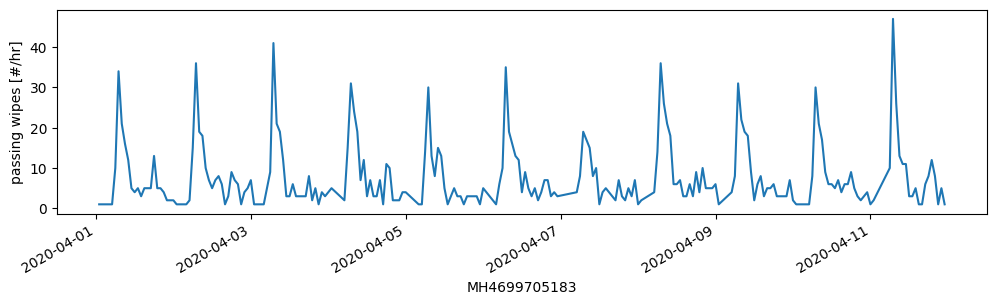

In [9]:
arrivals.plot(figsize=(12, 3), ylabel="passing wipes [#/hr]")

## 3. Get flowrates

In [10]:
s_flowrates = blockage_sim.read_flowrates()

<Axes: ylabel='flowrate [l/s]'>

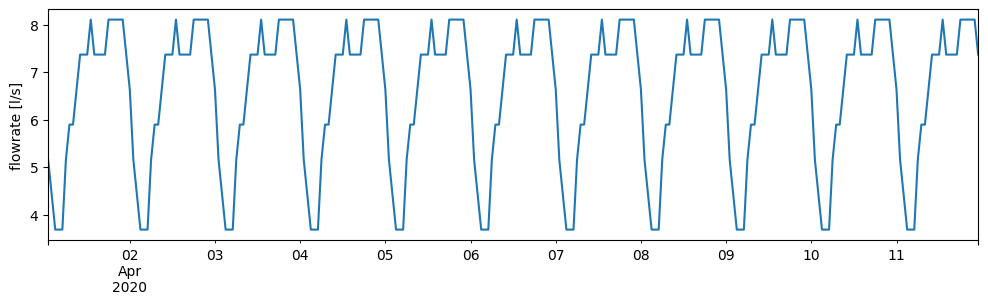

In [11]:
s_flowrates.plot(figsize=(12, 3), ylabel="flowrate [l/s]")

## 4. Simulate snagging and accumulation

In [12]:
# concatenate flowrates and arrivals to common dataframe
df = pd.concat([arrivals, s_flowrates], axis=1)
df["arrivals"].fillna(0, inplace=True)
# sample snagging and accumulating wipes from arriving
df = blockage_sim.sample_accumulation(df)

<Axes: ylabel='accumulation [#/hr]'>

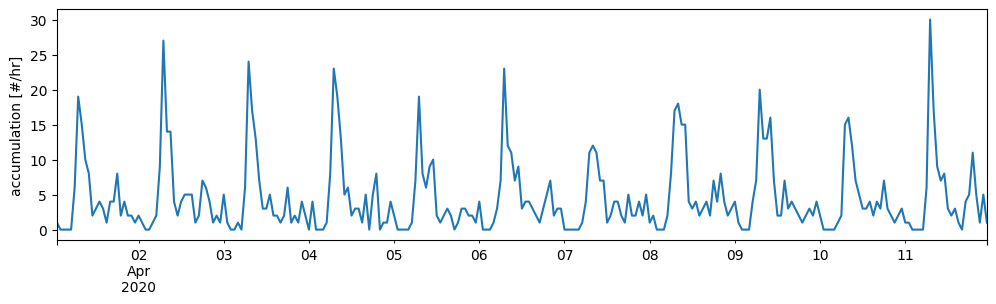

In [13]:
df["accumulation"].plot(figsize=(12, 3), ylabel="accumulation [#/hr]")

## 5. iteratively adapt orifice settings to hydraulic simulation 

In [15]:
df = blockage_sim.run_iterations(df, n_iterations=3, router=blockage_sim.router, bulk=True)

blockage_logger - INFO - starting iteration 1
blockage_logger - INFO - starting iteration 1
blockage_logger - INFO - calculating orifice settings
blockage_logger - INFO - calculating orifice settings
C:\Users\albert\PycharmProjects\PacketSWMM\apps\blockage.py:84: RuntimeWarning: overflow encountered in exp
  else:
C:\Users\albert\Projekte\ak_local\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
blockage_logger - INFO - running hydraulic model
blockage_logger - INFO - running hydraulic model
blockage_logger - INFO - Model run finished:
New rpt-file at C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\katys_model\rptfile_iteration1.rpt
New out-file at C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\katys_model\outfile_iteration1.out
blockage_logger - INFO - Model run finished:
New rpt-file at C:\Users\albert\PycharmProjects\PacketSWMM\sample_data\katys_model\rptfile

In [7]:
result_dict = {}
with pd.HDFStore(result_path) as store:
    for key in store.keys():
        result_dict[key] = store[key]

In [ ]:
result_dict[f"/iteration_1"].loc["2015-04-01":"2015-04-02", "depth"].plot()

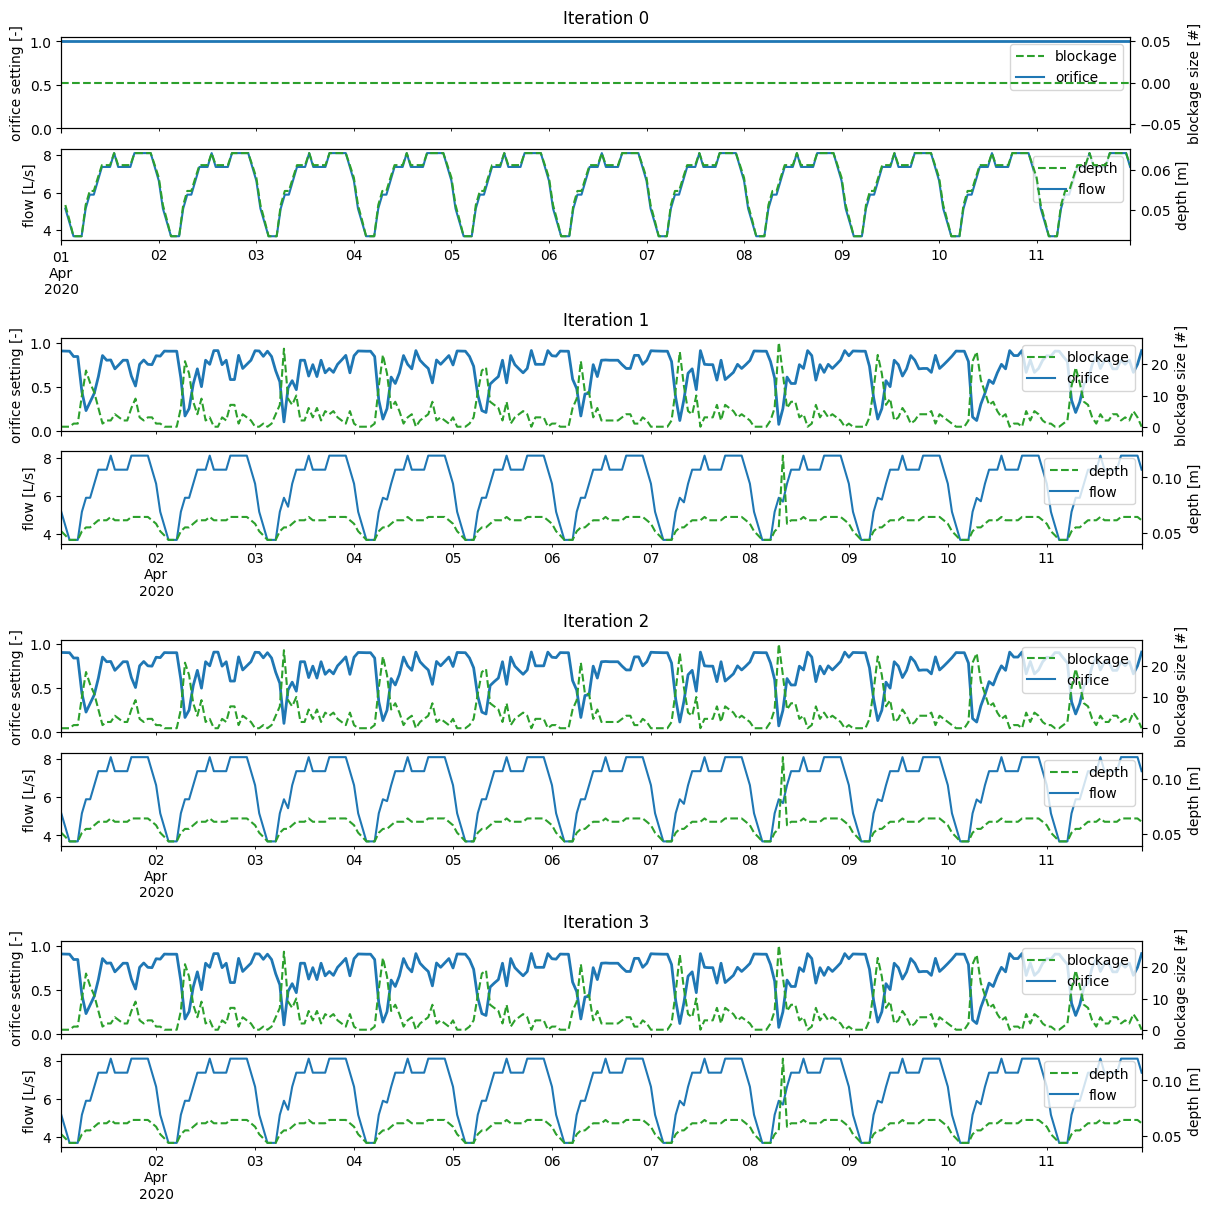

In [8]:
from matplotlib.lines import Line2D

n_iterations = len(result_dict)

fig = plt.figure(layout='constrained', figsize=(12, n_iterations*3))
subfigs = fig.subfigures(nrows=n_iterations, ncols=1)

for i in range(n_iterations):
    subfigs[i].suptitle(f"Iteration {i}")
    df = result_dict[f"/iteration_{i}"]
    axs = subfigs[i].subplots(nrows=2, sharex=True)
    df["orifice"].plot(ax=axs[0], ylim=[0, 1.05], ylabel="orifice setting [-]", lw=2.0)
    ax2 = axs[0].twinx()
    # Custom legend
    legend_elements = [
        Line2D([0], [0], color='tab:green', linestyle='dashed', label='blockage'),
        Line2D([0], [0], color='tab:blue', linestyle='solid', label='orifice')]
    df["blockage"].plot(ax=ax2, ylabel="blockage size [#]", c="tab:green", ls="dashed")
    axs[0].legend(handles=legend_elements, loc='upper right')
    
    df["flow"].plot(ax=axs[1], ylabel="flow [L/s]")
    ax2 = axs[1].twinx()
    try:
        df["depth"].plot(ax=ax2, ylabel="depth [m]", c="tab:green", ls="dashed")
    except:
        pass
    legend_elements = [
        Line2D([0], [0], color='tab:green', linestyle='dashed', label='depth'),
        Line2D([0], [0], color='tab:blue', linestyle='solid', label='flow')]
    axs[1].legend(handles=legend_elements, loc='upper right')

In [26]:
import numpy as np

def r2_score(y_true, y_pred):
    """
    Calculate the R-squared (coefficient of determination) score.

    Parameters:
    - y_true: array-like, true values
    - y_pred: array-like, predicted values

    Returns:
    - R-squared score
    """
    # Convert to numpy arrays if not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate total sum of squares and residual sum of squares
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    
    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)
    return r2


In [ ]:
corrs = {"flow":[],
         "blockage":[],
         "orifice":[]}


fig, axs = plt.subplots(ncols=3, figsize=[12, 3], constrained_layout=True)
fig.suptitle("Convergence of Iterations")
for ax in axs:
    ax.axhline(1.0, c="tab:orange", label="No change", lw=2.0)
    ax.set_xticks(np.arange(n_iterations-1))
    ax.set_xlabel("Iteration")
    ax.set_xlim((1, n_iterations-1))
    ax.grid(which="major", axis="both")
fig.supylabel("Pearson Correlation\nwith previous iteration")

for i in range(1, n_iterations):
    for val in ["flow", "blockage", "orifice"]:
        s1 = result_dict[f"/iteration_{i-1}"][val].rename("old")
        s2 = result_dict[f"/iteration_{i}"][val].rename("new")
        corrs[val].append(pd.concat([s1, s2], axis=1).corr().loc["old", "new"])

for i, val in enumerate(["flow", "blockage", "orifice"]):
    axs[i].plot(np.arange(1, n_iterations), corrs[val], marker="o", ls="dashed", label="PCC")
    axs[i].set(title="val")
axs[0].legend()

In [ ]:
corrs["orifice"]